# Preprocessing des données

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import io

#chargement pour google colab
#path = '/content/drive/MyDrive/Colab Notebooks/eco2mix-regional-cons-def.csv'
#df = pd.read_csv(path, sep = ';');

#chargement local
df = pd.read_csv('eco2mix-regional-cons-def.csv', sep=';')

C:\Users\romat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,56,58,60,62,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Voici le compte total des lignes de la database et le compte des lignes avec des NAN

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#compte de lignes et compte des NA
print(f'Nombre de lignes total = {len(df)}')
df.isna().sum()

Nombre de lignes total = 1787328


Code INSEE région                                                 0
Région                                                            0
Nature                                                            0
Date                                                              0
Heure                                                             0
Date - Heure                                                      0
Consommation (MW)                                                12
Thermique (MW)                                                   12
Nucléaire (MW)                                               744727
Eolien (MW)                                                     108
Solaire (MW)                                                     12
Hydraulique (MW)                                                 12
Pompage (MW)                                                 779767
Bioénergies (MW)                                                 12
Ech. physiques (MW)                             

### Suppression des colonnes et lignes inutiles et gestion des NA 
Comme vu dans le tableau ci-dessus, certaines colonnes ont un grand nombre de valeurs manquantes (plus de 80% des données). Nous allons supprimer les TCH et les flux car peu significatifs. Pour les TCO, il s'agit des taux de couverture de la consommation seulement calculés après 2020. Nous allons les calculer pour les années précédentes. 

Pour le reste, en ce qui concerne les données en MW, nous allons remplacer les données manquantes par des 0 (car il s'agit de régions sans production nucléaire par exemple) et nous allons supprimer 2 colonnes techniques ainsi que les lignes sans aucune donnée (au nombre de 12).

In [4]:
#drop des colonnes vides ou quasiment vides (les TCO sont les taux de couverture par filière, les flux sont incomplets, le TCH est inconnu)

filter_col2 = [col for col in df if col.startswith('TCH')]
filter_col3 = [col for col in df if col.startswith('Flux')]
filter_col = filter_col2 + filter_col3

df = df.drop(filter_col,axis=1)

#drop des colonnes inutiles (techniques)
df = df.drop(['Nature', 'Code INSEE région'],axis=1)

In [5]:
#drop des lignes sans data de consommation ou production
float_list = list(df.select_dtypes('float64').columns)
df = df.dropna(subset=float_list, how='all', axis=0)

#remplissage des NA par des 0 sur les colonnes de consommation et production
for column in float_list:
    df[column].fillna(0, inplace=True)
    
#remplissage des NAN des colonnes de taux de couverture de la consommation par le calcul correspondant
df['TCO Thermique (%)'].fillna((df['Thermique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Nucléaire (%)'].fillna((df['Nucléaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Eolien (%)'].fillna((df['Eolien (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Solaire (%)'].fillna((df['Solaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Hydraulique (%)'].fillna((df['Hydraulique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Bioénergies (%)'].fillna((df['Bioénergies (MW)'] / df['Consommation (MW)']*100), inplace=True)

### Création de nouvelles variables
En premier lieu, des colonnes pour agréger certaines données en MW (renouvelables, un solde brut sans transfert, un solde net avec transfert). Ensuite, nous allons créer des taux de couverture de la consommation. Enfin, nous allons extraire les données liées à la date de chaque ligne.

In [6]:
#feature engineering (création de colonnes agrégées)

df['Renouvelables (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Pompage (MW)']
df['Solde brut (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] - df['Consommation (MW)']
df['Solde avec transferts (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] + df['Ech. physiques (MW)'] - df['Consommation (MW)']
#remarque sur le pompage: uniquement des valeurs négatives donc représente la consommation d'électricité pour alimenter les pompes des stations de transfert d'énergie (STEP). La production doit alors être classifiée dans l'hydraulique.


#Taux de couvetures de la consommation

df['Taux Couverture (MW)'] = (df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)']) / df['Consommation (MW)']
df['Taux Couverture Renouvelables (MW)'] = df['Renouvelables (MW)'] / df['Consommation (MW)']

In [7]:
#Mise au format date et extraction des éléments de la date en tant que colonnes
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.weekday
df['Jour'] = df['Date'].dt.day
df['Mois'] = df['Date'].dt.month
df['Trimestre'] = pd.PeriodIndex(df['Date'], freq='Q').astype('string') # alternative: ((x.month-1)//3) +1
df['Année'] = df['Date'].dt.year
df['Heure'] = pd.to_datetime(df['Heure'], format='%H:%M').dt.time #alternative: format='%H:%M:%S'
df['Date - Heure'] = pd.to_datetime(df['Date - Heure'], utc=True)

In [8]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),TCO Thermique (%),TCO Nucléaire (%),TCO Eolien (%),TCO Solaire (%),TCO Hydraulique (%),TCO Bioénergies (%),Renouvelables (MW),Solde brut (MW),Solde avec transferts (MW),Taux Couverture (MW),Taux Couverture Renouvelables (MW),Weekday,Jour,Mois,Année
count,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00
mean,4499.02,373.95,3678.17,246.14,86.14,608.51,-65.87,81.66,-510.03,1.33,15.09,1.66,0.54,2.12,0.39,956.58,509.67,-0.36,1.22,0.20,3.00,15.72,6.35,2016.76
std,2173.38,537.57,3876.44,412.40,209.85,1040.19,243.05,44.55,4372.91,4.72,56.66,6.26,3.03,8.60,0.90,1117.32,4372.87,5.63,1.23,0.18,2.00,8.80,3.45,2.46
min,895.00,-83.00,-144.00,-6.00,-23.00,-14.00,-2570.00,4.00,-12219.00,-2.54,-2.98,-0.10,-0.08,-1.06,0.00,-1280.00,-13960.00,-704.00,-0.18,-0.24,0.00,1.00,1.00,2013.00
25%,2789.00,24.00,0.00,26.00,0.00,5.00,-1.00,46.00,-4264.00,0.00,0.00,0.00,0.00,0.00,0.00,192.00,-2229.00,-1.00,0.20,0.06,1.00,8.00,3.00,2015.00
50%,4111.00,153.00,2583.00,101.00,0.00,57.00,0.00,72.00,473.00,0.00,0.00,0.00,0.00,0.00,0.00,471.00,-473.00,0.00,0.90,0.14,3.00,16.00,6.00,2017.00
75%,5741.00,480.00,6845.00,289.00,63.00,897.00,0.00,114.00,2229.00,0.00,0.00,0.00,0.00,0.00,0.00,1370.00,4264.00,0.00,1.86,0.29,5.00,23.00,9.00,2019.00
max,15338.00,4293.00,13632.00,4554.00,2392.00,8742.00,0.00,404.00,13959.00,56.89,787.27,100.50,59.47,115.57,7.33,9120.00,12218.00,700.00,8.09,1.31,6.00,31.00,12.00,2021.00


# Modèle Itération 1 : prévisions de production des renouvelables

Création d'un dataframe temporaire avec les dates en index et la production cumulée de renouvelables en série

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import scipy.stats
import datetime
%matplotlib inline

In [10]:
'''#Groupby Hour
temp_df = df.groupby(['Date - Heure']).sum().reset_index()
temp_df['Date - Heure'] = temp_df['Date - Heure'].dt.round('H')
temp_df = temp_df.groupby(['Date - Heure']).sum().reset_index()
temp_df.set_index('Date - Heure', inplace=True)'''

"#Groupby Hour\ntemp_df = df.groupby(['Date - Heure']).sum().reset_index()\ntemp_df['Date - Heure'] = temp_df['Date - Heure'].dt.round('H')\ntemp_df = temp_df.groupby(['Date - Heure']).sum().reset_index()\ntemp_df.set_index('Date - Heure', inplace=True)"

In [11]:
'''#Groupby Week
temp_df = df.groupby(['Date']).sum().reset_index()
temp_df.set_index('Date', inplace=True)
temp_df = temp_df.groupby(pd.Grouper(freq='w')).sum()'''

"#Groupby Week\ntemp_df = df.groupby(['Date']).sum().reset_index()\ntemp_df.set_index('Date', inplace=True)\ntemp_df = temp_df.groupby(pd.Grouper(freq='w')).sum()"

In [12]:
'''#Groupby Day
temp_df = df.groupby(['Date']).sum().reset_index()
temp_df.set_index('Date', inplace=True)
temp_df = temp_df.groupby(pd.Grouper(freq='D')).sum()'''

"#Groupby Day\ntemp_df = df.groupby(['Date']).sum().reset_index()\ntemp_df.set_index('Date', inplace=True)\ntemp_df = temp_df.groupby(pd.Grouper(freq='D')).sum()"

In [13]:
#Groupby Month - modèle utilisé ici
temp_df = df.groupby(['Date']).sum().reset_index()
temp_df.set_index('Date', inplace=True)
temp_df = temp_df.groupby(pd.Grouper(freq='M')).sum()

In [14]:
temp_df.head()

,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),TCO Thermique (%),TCO Nucléaire (%),TCO Eolien (%),TCO Solaire (%),TCO Hydraulique (%),TCO Bioénergies (%),Renouvelables (MW),Solde brut (MW),Solde avec transferts (MW),Taux Couverture (MW),Taux Couverture Renouvelables (MW),Weekday,Jour,Mois,Année
Date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-31,106515355.00,12575951.00,84708335.00,2627826.00,275544.00,13618137.00,-1204944.00,1089974.00,-7229744.00,0.00,0.00,0.00,0.00,0.00,0.00,16406537.00,7175468.00,-54276.00,20653.76,2448.86,51828,285684,17844,35919972
2013-02-28,98659091.00,12699120.00,73478789.00,2911326.00,441789.00,13528331.00,-945548.00,981454.00,-4486185.00,0.00,0.00,0.00,0.00,0.00,0.00,16917352.00,4436170.00,-50015.00,18213.01,2520.74,48384,233856,32256,32465664
2013-03-31,98492373.00,12589251.00,73628178.00,2689621.00,666161.00,12713769.00,-1200411.00,1067519.00,-3721243.00,0.00,0.00,0.00,0.00,0.00,0.00,15936659.00,3661715.00,-59528.00,20047.58,2685.22,57024,285696,53568,35944128
2013-04-30,80269032.00,6082453.00,62938389.00,2963937.00,839159.00,14237985.00,-1085516.00,846559.00,-6611003.00,0.00,0.00,0.00,0.00,0.00,0.00,17802124.00,6553934.00,-57069.00,20062.63,3588.00,48960,267840,69120,34784640
2013-05-31,73323639.00,2904908.00,62265278.00,2290765.00,972577.00,17002185.00,-1349586.00,979575.00,-11796422.00,0.00,0.00,0.00,0.00,0.00,0.00,19895516.00,11742063.00,-54359.00,22019.09,4333.10,53568,285696,89280,35944128


Analyse de l'effet saisonnier: l'utilisation d'un modèle logarithmique grâce au paramètre "multiplicative" permet de stabiliser les résidus et de les rendre aléatoires.
On remarque la tendance qui est à la croissance depuis 2017.
Egalement, l'effet saisonnier est marqué avec des pics de production lors des hivers et des minimums à l'été.

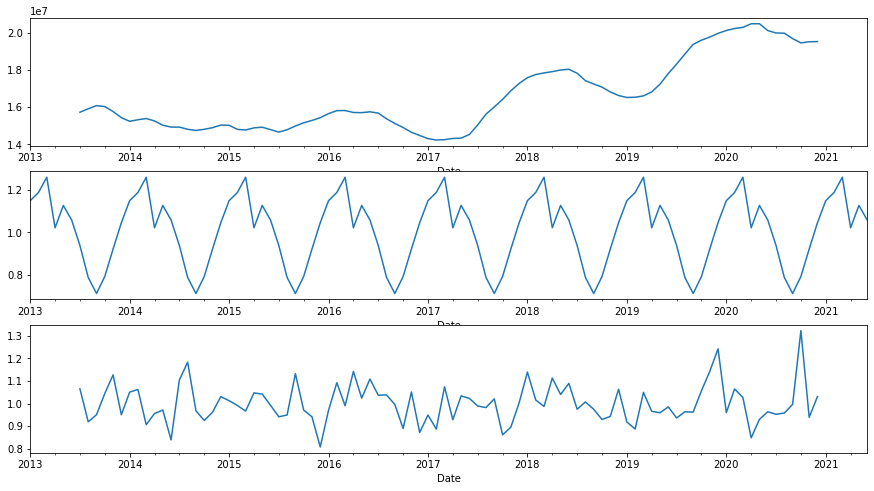

In [15]:
season_effect = seasonal_decompose(temp_df['Renouvelables (MW)'], model='multiplicative') #, freq=365
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
season_effect.trend.plot(ax=ax1)
season_effect.seasonal.plot(ax=ax2)
season_effect.resid.plot(ax=ax3)
plt.show();

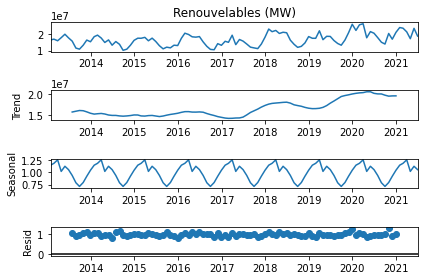

In [16]:
#Analyse du trend selon le pas choisi
time_serie = temp_df['Renouvelables (MW)']
season_effect = seasonal_decompose(time_serie, model='multiplicative') #, freq=365
season_effect.plot()
plt.show();

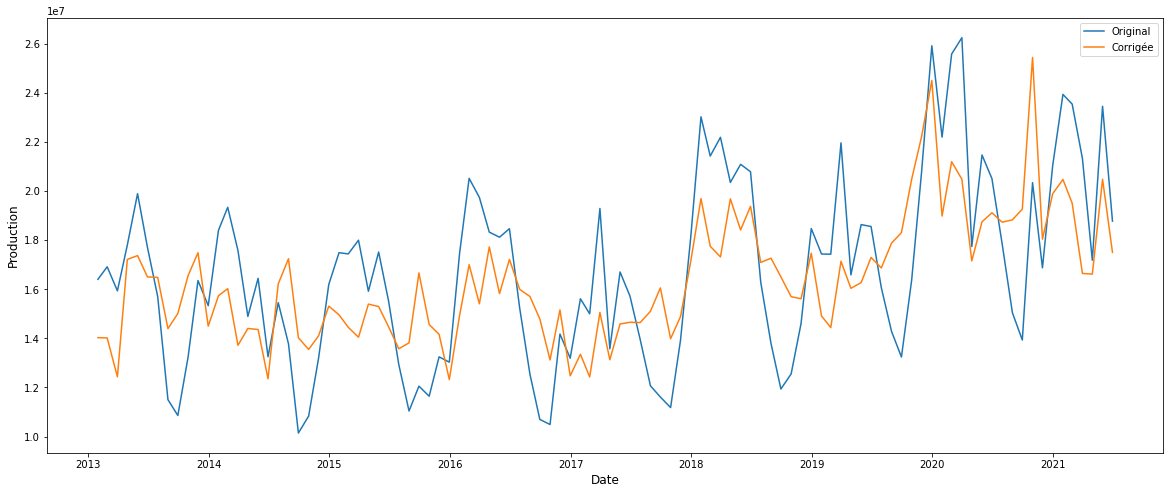

In [17]:
#Comparaison réel vs corrigé des effets saisonniers
time_serie_log = np.log(time_serie)
season_effect = seasonal_decompose(time_serie_log)
cvs = time_serie_log - season_effect.seasonal
x_cvs = np.exp(cvs)

plt.figure(figsize=(20,8))
plt.plot(time_serie, label='Original')
plt.plot(x_cvs, label='Corrigée')
plt.ylabel('Production', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.show();

Même si ce n'est pas la représentation la plus claire, on voit que les pics réels sont le plus souvent gommés dans la courbe saisonnière.

## ARIMA sur un pas mensuel: différenciation

On commence par une première différenciation avec un pas de 1. On peut remarquer que le graphique d'autocorrélation donne toujours une tendance cyclique même si cela converge vers 0 in fine.

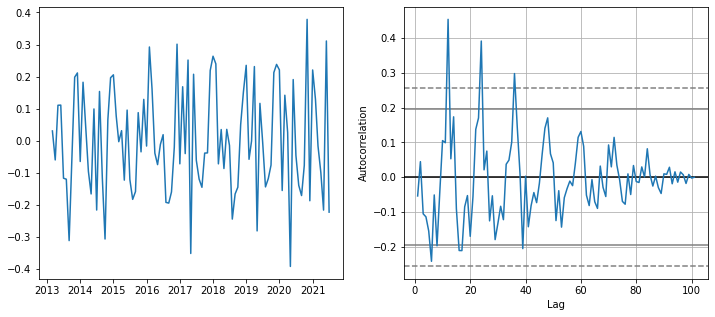

In [18]:
time_serie_log1 = time_serie_log.diff(1).dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(time_serie_log1)
pd.plotting.autocorrelation_plot(time_serie_log1, ax=ax2);

Nous allons effectuer une différenciation sur une période de 12 mois: on voit dans le graphique ci-dessus que cela pourrait être un cycle de cette ordre mais il paraît également logique instinctivement de suivre une telle saisonnalité (équivalente à 1 an).

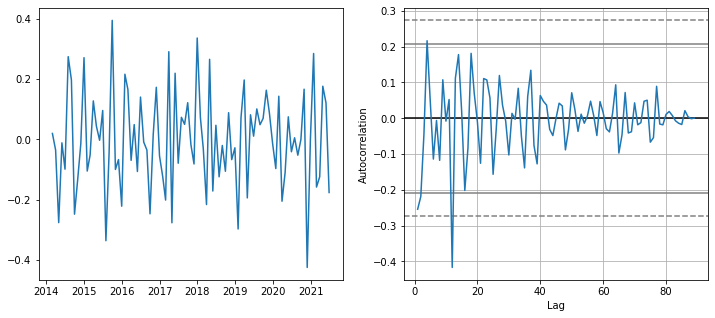

In [19]:
time_serie_log2 = time_serie_log1.diff(12).dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(time_serie_log2)
pd.plotting.autocorrelation_plot(time_serie_log2, ax=ax2);

In [20]:
#P-value de la validité de la stationarité
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(time_serie_log2)
print(f'P-value AdFuller: {p_value}')

P-value AdFuller: 8.597024412577399e-06


Comme on pouvait s'en douter, l'autocorrélation converge très vite vers 0 et la p-value du test visant à vérifier l'hypothèse de non-stationnarité est très faible. On peut donc présumer que ce set de données est bien stationnaire.
Nous pouvons utiliser un modèle SARIMAX.

## ARIMA sur un pas mensuel: modèle SARIMAX

### Modèle sur toutes les données

En traçant les graphiques d'autocorrélation, on va déterminer les paramètres du modèle:
- pour la partie non saisonnière, on voit que les 2 graphiques convergent vers 0, nous allons partir vers p = q = 1, sachant que d = 1 puisque nous avions effectuer une première différenciation
- pour la partie saisonnière, D = 1 et la période est de 12 grâce à la seconde différenciation. Au niveau des paramètres, on va prendre p = q = 1 car quand on prend les points 12/24), même si on voit un pic au rang 12, on a plutôt l'impression que les courbes convergent vers 0.

C:\Users\romat\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


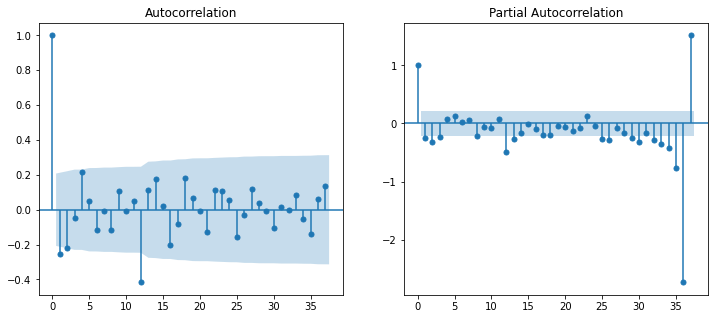

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
plot_acf(time_serie_log2, ax=ax1, lags = 37)
plot_pacf(time_serie_log2, ax=ax2, lags = 37)
plt.show();

In [22]:
model = sm.tsa.SARIMAX(time_serie_log,order=(1,1,1), seasonal_order=(1,1,1,12))
model_fitted = model.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 Renouvelables (MW)   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  60.765
Date:                            Tue, 24 Aug 2021   AIC                           -111.529
Time:                                    11:42:40   BIC                            -99.086
Sample:                                01-31-2013   HQIC                          -106.514
                                     - 06-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3935      0.133      2.957      0.003       0.133       0.654
ma.L1         -0.9111      0.077    -11.846      0.000      -1.062      -0.760
ar.S.L12      -0.4124      0.188     -2.193      0.028      -0.781      -0.044
ma.S.L12      -0.2896      0.207     -1.400      0.162      -0.695       0.116
sigma2         0.0137      0.002      6.249      0.000       0.009       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.79   Prob(JB):                         0.73
Heteroskedasticity (H):               1.30   Skew:                             0.16
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Comme la p-value du paramètre MA saisonnier est de 0.162, nous allons le supprimer. Q=0

In [23]:
model = sm.tsa.SARIMAX(time_serie_log,order=(1,1,1), seasonal_order=(1,1,0,12))
model_fitted = model.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                  Renouvelables (MW)   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                  59.942
Date:                             Tue, 24 Aug 2021   AIC                           -111.883
Time:                                     11:42:41   BIC                           -101.929
Sample:                                 01-31-2013   HQIC                          -107.871
                                      - 06-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3985      0.128      3.110      0.002       0.147       0.650
ma.L1         -0.9288      0.063    -14.713      0.000      -1.053      -0.805
ar.S.L12      -0.5931      0.085     -6.940      0.000      -0.761      -0.426
sigma2         0.0141      0.002      6.422      0.000       0.010       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.89   Prob(JB):                         0.83
Heteroskedasticity (H):               1.20   Skew:                             0.13
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Nous avons un modèle qui a priori fonctionne correctement avec des tests de Ljung-Box et Jarque-bera indiquant la blancheur des résidus ainsi que leur normalité.

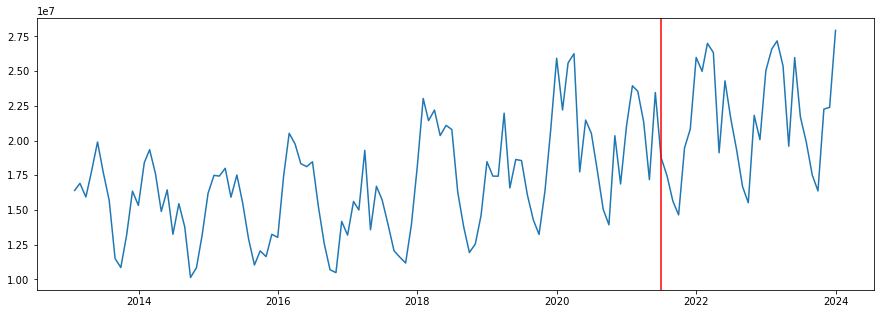

In [24]:
pred = np.exp(model_fitted.predict(102,131))
time_serie_pred = pd.concat([time_serie, pred])
plt.figure(figsize = (15,5))
plt.plot(time_serie_pred)
plt.axvline(x=datetime.date(2021,6,30), color='red')
plt.show();

En étalant la prédiction jusqu'à 2024:

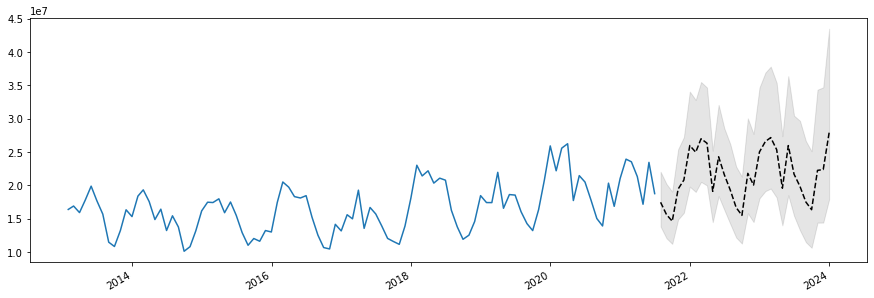

In [25]:
prediction = model_fitted.get_forecast(steps=30).summary_frame()  #Prédiction avec intervalle de confiance

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(time_serie)
prediction = np.exp(prediction) #Passage à l'exponentielle

prediction['mean'].plot(ax = ax, style = 'k--') #Visualisation de la moyenne

ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1);

In [26]:
frame = {'Renouvelables (MW)': pred}
pred_df = pd.DataFrame(frame, index=pred.index)

Nous allons essayer de mesurer la précision du modèle en le faisant fonctionner sur ses derniers 18 mois et en mesurant son erreur. Même si c'est une comparaison face à des données utilisées pour l'entraînement, cela peut donner une mesure utile de l'efficacité du modèle.

In [27]:
pred_20_21 = np.exp(model_fitted.predict(84,101))
real_20_21 = time_serie.loc['2020-1-31':'2021-06-30']

num = np.sum(np.abs(pred_20_21-real_20_21))/12
denom = np.mean(real_20_21)
error = num/denom
print(f'Erreur moyenne relative: {"{:.1f}".format(error*100)}%')

Erreur moyenne relative: 16.7%


L'erreur moyenne relative représente environ 17% de la réalité, ce qui est loin d'être négligeable. Ci-dessous le RMSE donne approximativement le même ordre d'erreur par rapport à la production moyenne de renouvelables sur l'échantillon utilisé.

In [28]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(pred_20_21, real_20_21))
print(f'RMSE Score: {"{:.0f}".format(rmse)}')
print(f'Réel moyen: {"{:.0f}".format(time_serie.mean())}')
print(f'Rapport: {"{:.1f}".format(100*rmse/time_serie.mean())}%')

RMSE Score: 2899247
Réel moyen: 16761913
Rapport: 17.3%


# Modèle Itération 1 : prévisions de consommation

On peut voir ci-dessous que la consommation a connu un changement de tendance à la baisse à partir de début 2020 et cela coincide avec le début de la pandémie du Covid-19.

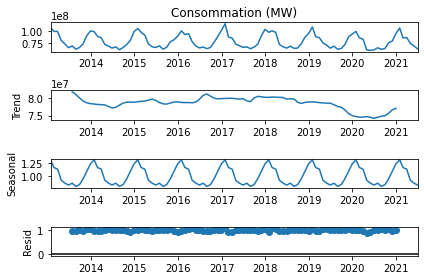

In [29]:
#Analyse du trend selon le pas choisi
time_serie = temp_df['Consommation (MW)']
#BC, lamb = scipy.stats.boxcox(temp_df['Consommation (MW)'])
#time_serie = pd.Series(BC, index=temp_df.index)
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #prob = scipy.stats.boxcox_normplot(time_serie, -2, 2, plot=ax)
season_effect = seasonal_decompose(time_serie, model='multiplicative') #, freq=365
season_effect.plot()
plt.show();

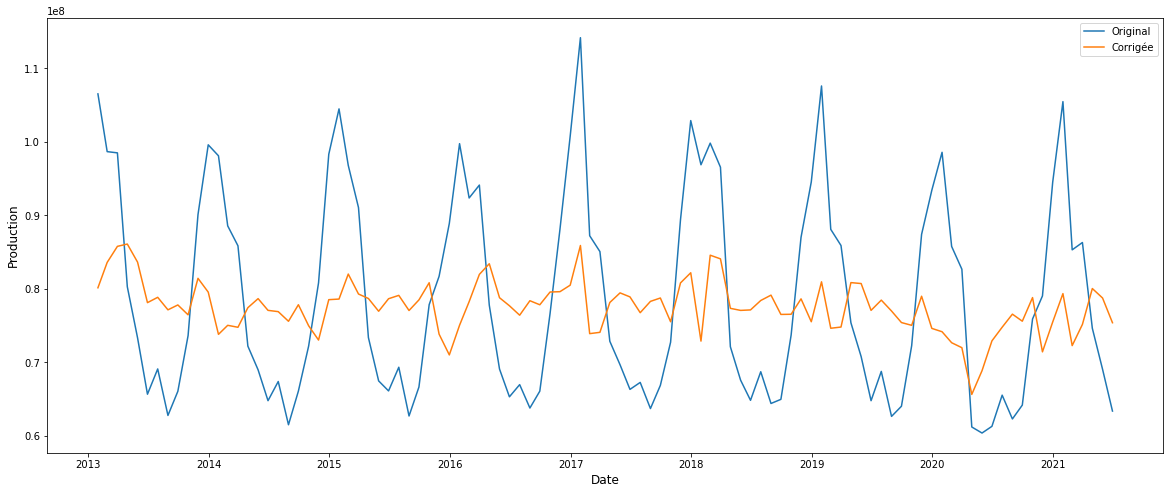

In [30]:
#Comparaison réel vs corrigé des effets saisonniers
time_serie_log = np.log(time_serie)
season_effect = seasonal_decompose(time_serie_log)
cvs = time_serie_log - season_effect.seasonal
x_cvs = np.exp(cvs)

plt.figure(figsize=(20,8))
plt.plot(time_serie, label='Original')
plt.plot(x_cvs, label='Corrigée')
plt.ylabel('Production', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.show();

## Différenciation

On commence comme précédemment avec une différenciation avec un pas de 1.

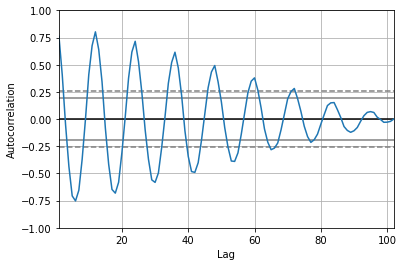

In [31]:
pd.plotting.autocorrelation_plot(time_serie_log);

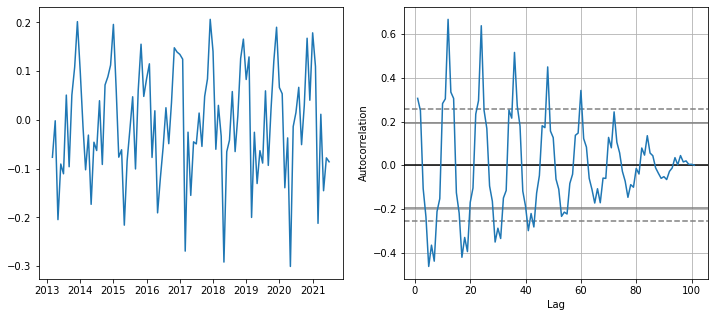

In [32]:
time_serie_log1 = time_serie_log.diff(1).dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(time_serie_log1)
pd.plotting.autocorrelation_plot(time_serie_log1, ax=ax2);

On enchaîne logiquement avec une différenciation de 12 mois.

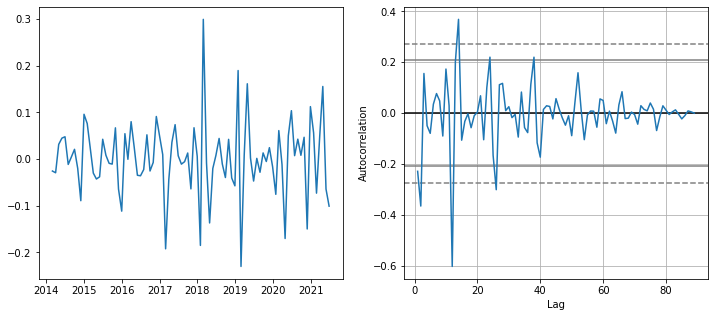

In [33]:
time_serie_log2 = time_serie_log1.diff(12).dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(time_serie_log2)
pd.plotting.autocorrelation_plot(time_serie_log2, ax=ax2);

In [34]:
#P-value de la validité de la stationarité
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(time_serie_log2)
print(f'P-value AdFuller: {p_value}')

P-value AdFuller: 0.00018076997970475355


Comme on pouvait s'en douter, l'autocorrélation converge très vite vers 0 et la p-value du test visant à vérifier l'hypothèse de non-stationnarité est très faible. On peut donc présumer que ce set de données est bien stationnaire.
Nous pouvons utiliser un modèle SARIMAX.

## SARIMAX

### Toutes données

En traçant les graphiques d'autocorrélation, on va déterminer les paramètres du modèle:
- pour la partie non saisonnière, on voit que les 2 graphiques convergent vers 0, nous allons partir vers p = q = 1, sachant que d = 1 puisque nous avions effectuer une première différenciation
- pour la partie saisonnière, D = 1 et la période est de 12 grâce à la seconde différenciation. Au niveau des paramètres, on va prendre p = q = 1 car quand on prend les points 12/24), même si on voit un pic au rang 12, on a plutôt l'impression que les courbes convergent vers 0.

C:\Users\romat\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


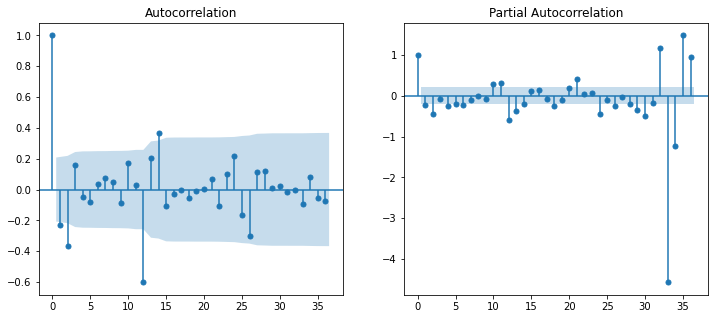

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
plot_acf(time_serie_log2, ax=ax1, lags = 36)
plot_pacf(time_serie_log2, ax=ax2, lags = 36)
plt.show();

In [36]:
model = sm.tsa.SARIMAX(time_serie_log,order=(1,1,1), seasonal_order=(1,1,1,12))
model_fitted = model.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  Consommation (MW)   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 146.886
Date:                            Tue, 24 Aug 2021   AIC                           -283.773
Time:                                    11:42:44   BIC                           -271.330
Sample:                                01-31-2013   HQIC                          -278.757
                                     - 06-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3270      0.137      2.393      0.017       0.059       0.595
ma.L1         -0.8867      0.081    -10.886      0.000      -1.046      -0.727
ar.S.L12      -0.3873      0.125     -3.107      0.002      -0.632      -0.143
ma.S.L12      -0.8151      0.222     -3.673      0.000      -1.250      -0.380
sigma2         0.0017      0.000      6.060      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.37
Prob(Q):                              0.99   Prob(JB):                         0.02
Heteroskedasticity (H):               1.44   Skew:                            -0.68
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ce modèle est problématique car même si le test de Ljung-Box montre la blancheur des résidus, celui de Jarque-Bera rejette la normalité. Le problème pourrait se situer en partie avec la rupture impliquée par la baisse de consommation liée au Covid qui rend moins claire la tendance future.

In [37]:
#model_fitted.plot_diagnostics(figsize=(15, 12))

En prédisant jusqu'à 2024:

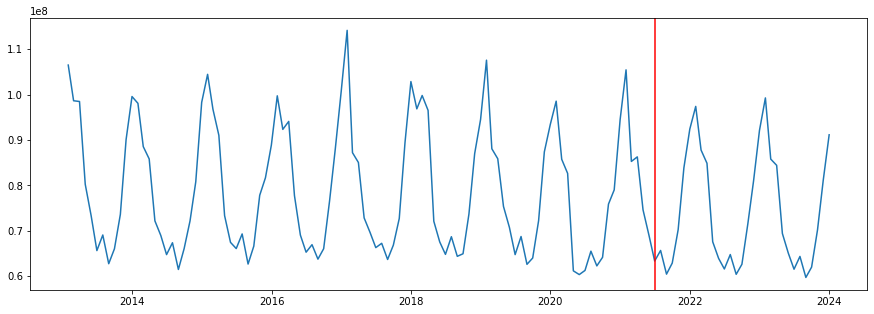

In [38]:
pred = np.exp(model_fitted.predict(102,131))
time_serie_pred = pd.concat([time_serie, pred])
plt.figure(figsize = (15,5))
plt.plot(time_serie_pred)
plt.axvline(x=datetime.date(2021,6,30), color='red')
plt.show();

Nous allons essayer de mesurer la précision du modèle en le faisant fonctionner sur ses derniers 18 mois et en mesurant son erreur. Même si c'est une comparaison face à des données utilisées pour l'entraînement, cela peut donner une mesure utile de l'efficacité du modèle.


In [39]:
pred_20_21 = np.exp(model_fitted.predict(84,101))
real_20_21 = time_serie.loc['2020-1-31':'2021-06-30']

num = np.sum(np.abs(pred_20_21-real_20_21))/12
denom = np.mean(real_20_21)
error = num/denom
print(f'Erreur moyenne relative: {"{:.1f}".format(error*100)}%')

Erreur moyenne relative: 5.9%


L'erreur moyenne relative représente environ 6% de la réalité, ce qui est relativement efficace. Cependant, comme il s'agit de l'année de Covid, cela veut dire que le modèle est bien paramétré pour prendre en compte cet effet pandémique. Cela peut être problématique pour effectuer des prévisions fiables dans l'avenir. Ci-dessous le RMSE donne approximativement le même ordre d'erreur par rapport à la consommation moyenne sur l'échantillon utilisé.

In [40]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(pred_20_21, real_20_21))
print(f'RMSE Score: {"{:.0f}".format(rmse)}')
print(f'Réel moyen: {"{:.0f}".format(time_serie.mean())}')
print(f'Rapport: {"{:.1f}".format(100*rmse/time_serie.mean())}%')

RMSE Score: 3863769
Réel moyen: 78835038
Rapport: 4.9%


### Modèle hors données Covid

Nous allons donc tenter de créer un modèle similaire mais en l'entraînant jusqu'à fin 2019 pour exclure les données liées à la pandémie et essayer de limiter les effets de ce choc exogène sur la consommation.

In [41]:
time_serie_short = time_serie.loc['2013-1-1':'2019-12-31']
time_serie_log = np.log(time_serie_short)

model_short = sm.tsa.SARIMAX(time_serie_log,order=(1,1,1), seasonal_order=(1,1,1,12))
model_short_fitted = model_short.fit()
model_short_fitted.summary()

C:\Users\romat\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  Consommation (MW)   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 120.049
Date:                            Tue, 24 Aug 2021   AIC                           -230.098
Time:                                    11:42:45   BIC                           -218.785
Sample:                                01-31-2013   HQIC                          -225.599
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2447      0.143      1.706      0.088      -0.036       0.526
ma.L1         -0.9439      0.127     -7.425      0.000      -1.193      -0.695
ar.S.L12      -0.3491      0.163     -2.147      0.032      -0.668      -0.030
ma.S.L12      -0.9452      1.610     -0.587      0.557      -4.101       2.211
sigma2         0.0013      0.002      0.660      0.509      -0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.78   Prob(JB):                         0.47
Heteroskedasticity (H):               0.80   Skew:                            -0.35
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Nous allons paramétrer Q=0 étant donné que la p-value du Q saisonnier est très élevée.

In [42]:
model_short = sm.tsa.SARIMAX(time_serie_log,order=(1,1,1), seasonal_order=(1,1,0,12))
model_short_fitted = model_short.fit()
model_short_fitted.summary()

C:\Users\romat\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   Consommation (MW)   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 110.332
Date:                             Tue, 24 Aug 2021   AIC                           -212.665
Time:                                     11:42:46   BIC                           -203.614
Sample:                                 01-31-2013   HQIC                          -209.066
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3075      0.118      2.601      0.009       0.076       0.539
ma.L1         -0.9848      0.135     -7.307      0.000      -1.249      -0.721
ar.S.L12      -0.6365      0.090     -7.052      0.000      -0.813      -0.460
sigma2         0.0023      0.000      4.763      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.89   Prob(JB):                         0.62
Heteroskedasticity (H):               1.13   Skew:                            -0.27
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ce modèle est satisfaisant, que cela soit au niveau des p-values que des tests de Ljung-Box et Jarque-Bera qui indiquent une blancheur des résidus ainsi que leur normalité.

In [43]:
pred_20_21 = np.exp(model_short_fitted.predict(84,101))
real_20_21 = time_serie.loc['2020-1-31':'2021-06-30']

num = np.sum(np.abs(pred_20_21-real_20_21))/12
denom = np.mean(real_20_21)
error = num/denom
print(f'Erreur moyenne relative: {"{:.1f}".format(error*100)}%')

Erreur moyenne relative: 7.2%


In [44]:
rmse = np.sqrt(mean_squared_error(pred_20_21, real_20_21))
print(f'RMSE Score: {"{:.0f}".format(rmse)}')
print(f'Réel moyen: {"{:.0f}".format(time_serie.mean())}')
print(f'Rapport: {"{:.1f}".format(100*rmse/time_serie.mean())}%')

RMSE Score: 5097783
Réel moyen: 78835038
Rapport: 6.5%


Les erreurs quant à elles sont plus élevées que lors du Sarimax prenant toutes les données jusqu'à mi-2021. Cela paraît logique car le modèle va être moins ajusté au choc exogène qu'a été le Covid. Dans notre cas, cela peut être même préférable.

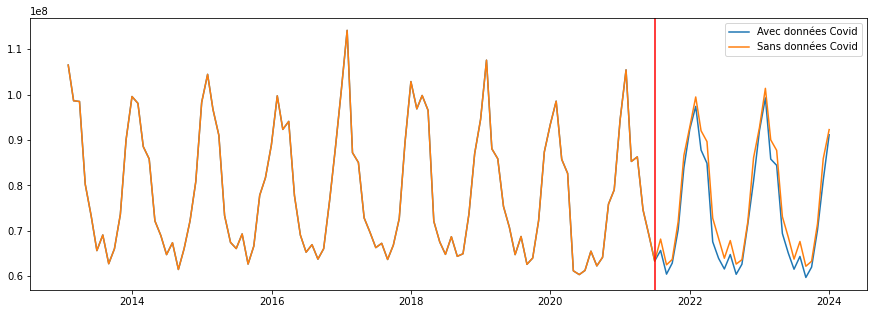

In [45]:
pred_short = np.exp(model_short_fitted.predict(102,131))
time_serie_pred_short = pd.concat([time_serie, pred_short])
plt.figure(figsize = (15,5))
plt.plot(time_serie_pred, label='Avec données Covid')
plt.plot(time_serie_pred_short, label='Sans données Covid')
plt.axvline(x=datetime.date(2021,6,30), color='red')
plt.legend()
plt.show();

Comme on peut le voir, le modèle sans les données Covid va effectuer des prévisions plus élevées que le modèle les prenant en compte.

**Considérant que le Covid est un choc exogène est en principe non permanent sur la série temporelle (car lié aux confinements successifs qui ne sont pas voués à se prolonger indéfiniment), nous allons conserver le modèle sans les données Covid.**

In [46]:
pred_df['Consommation (MW)'] = pred_short

# Modèle itération 1: taux de couverture des renouvelables, prévisionnel

Nous allons faire un graphique permettant de voir l'évolution du taux de couverture de la consommation par les renouvelables sur les prochaines années en prévisionnel. En rouge, on peut voir la limite entre données réelles et données prévisionnelles.

In [47]:
union = temp_df[['Renouvelables (MW)', 'Consommation (MW)']]
couv_df = pd.concat([union, pred_df], axis=0)
couv_df['Autre_conso'] = couv_df['Consommation (MW)'] - couv_df['Renouvelables (MW)']
couv_df['Taux Couverture Renouvelables (MW)'] = couv_df['Renouvelables (MW)'] / couv_df['Consommation (MW)']

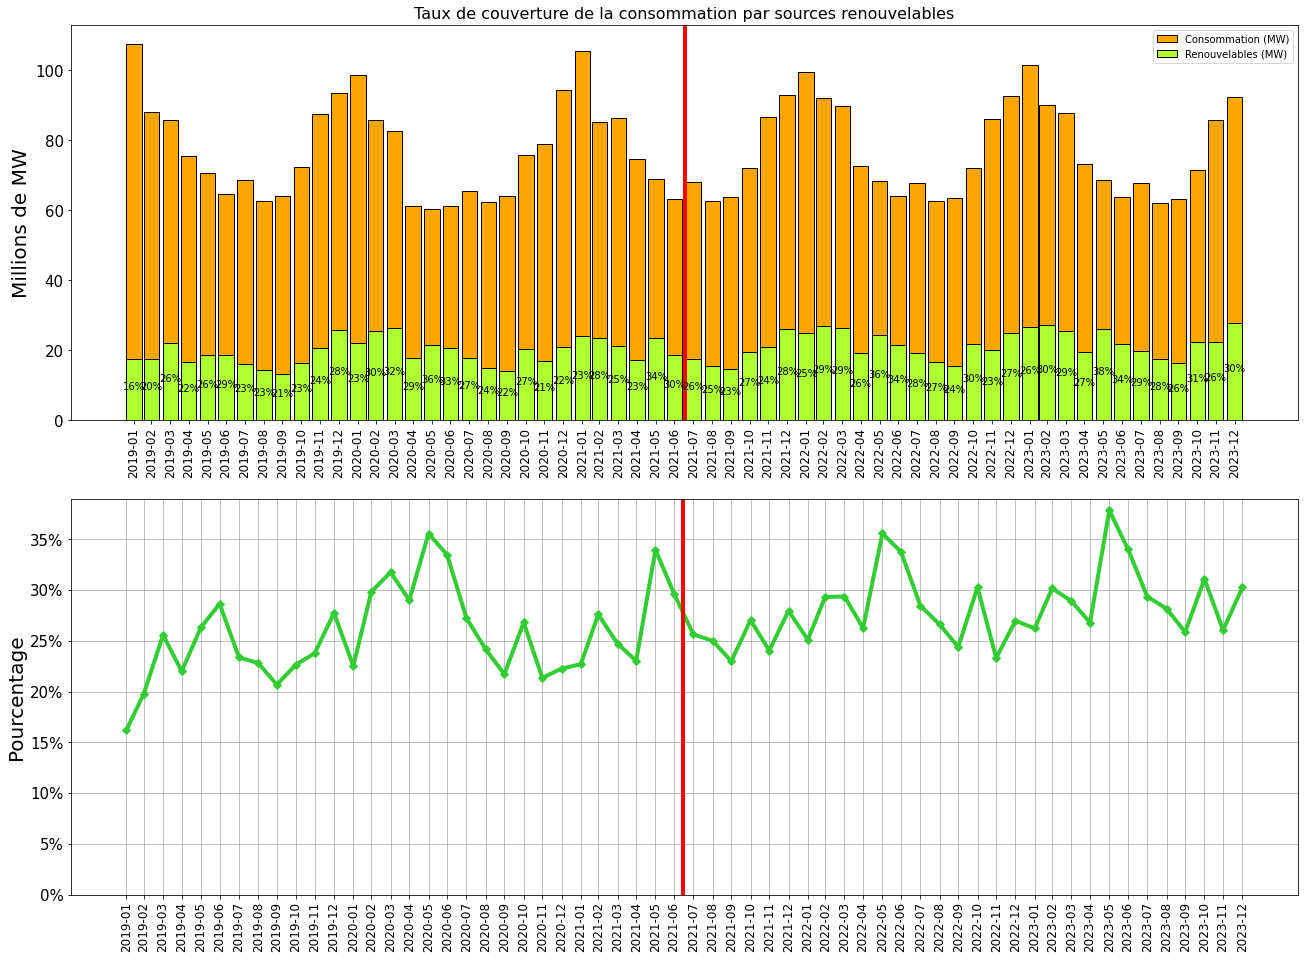

In [48]:
graph_df = couv_df.loc['2019-1-31':'2023-12-31']
barwidth=25
fig = plt.figure(figsize=(22,16))
ax = fig.add_subplot(211)
ax.bar(x=graph_df.index, height=graph_df['Autre_conso'], bottom = graph_df['Renouvelables (MW)'], 
        label = 'Consommation (MW)', width = barwidth, color='orange', edgecolor='black')
graph = ax.bar(x=graph_df.index, height=graph_df['Renouvelables (MW)'], 
                label = 'Renouvelables (MW)', width = barwidth, color='greenyellow', edgecolor='black')
ax.axvline(x=datetime.date(2021,7,17), color='red', linewidth=4)

ax.set_title('Taux de couverture de la consommation par sources renouvelables', fontsize=16)
ax.tick_params(labelsize=12)
ax.set_xticks(graph_df.index)
ax.set_xticklabels(graph_df.index.to_period('M'))
ax.tick_params('x', labelrotation = 90)

ax.set_yticks(np.arange(0,120000000,20000000))
ax.set_yticklabels([0,20,40,60,80,100])
ax.set_ylabel('Millions de MW', fontsize=20)
ax.tick_params('y', labelsize = 15)

#mise en place des pourcentages dans le graphique
i=0
for p in graph:
        percentage = "{:.0f}".format(round(graph_df.iloc[i,3]*100, 0))
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()/2
        ax.text(x=x, y=y, s = f'{percentage}%', ha='center', color='black', size=10)
        i += 1

ax.legend()

ax2 = fig.add_subplot(212)
ax2.plot(graph_df['Taux Couverture Renouvelables (MW)'], marker='D', color="limegreen", linewidth=4)
ax2.axvline(x=datetime.date(2021,7,15), color='red', linewidth=4)

'''for i, txt in enumerate(graph_df['Taux Couverture Renouvelables (MW)']):
    txt = "{:.0f}".format(txt*100)
    ax2.annotate(txt, (graph_df.index[i], graph_df.iloc[i,3]), size=15)'''

ax2.tick_params(labelsize=12)
ax2.set_xticks(graph_df.index)
ax2.set_xticklabels(graph_df.index.to_period('M'))
ax2.tick_params('x', labelrotation = 90)

ax2.set_yticks(np.arange(0,0.4,0.05))
ax2.set_yticklabels(['0%','5%','10%','15%','20%','25%', '30%', '35%'], fontsize = 10)
ax2.set_ylabel('Pourcentage', fontsize=20)
ax2.tick_params('y', labelsize = 15)
ax2.grid()
plt.show();

**Comme on peut le voir, le modèle prévoit une tendance à la hausse du taux de couverture des renouvelables dans l'avenir proche, d'une part grâce à une hausse régulière de la production de renouvelables, et d'autre part par une consommation qui va rester assez stable (malgré une remontée progressive post-Covid).**

# Modèle : prévision de production nucléaire

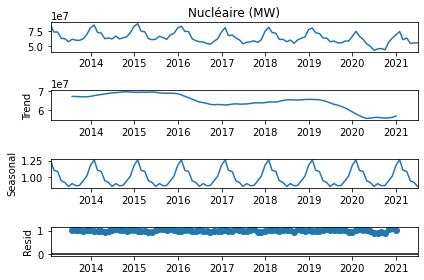

In [49]:
#Analyse du trend selon le pas choisi
time_serie = temp_df['Nucléaire (MW)']
#BC, lamb = scipy.stats.boxcox(temp_df['Consommation (MW)'])
#time_serie = pd.Series(BC, index=temp_df.index)
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #prob = scipy.stats.boxcox_normplot(time_serie, -2, 2, plot=ax)
season_effect = seasonal_decompose(time_serie, model='multiplicative') #, freq=365
season_effect.plot()
plt.show();

On peut voir ci-dessus que la production nucléaire a connu un renversement de tendance à la baisse en 2016 puis en 2020, le dernier moment coincidant avec le début de la pandémie du Covid-19. On peut supposer que la production nucléaire est une variable d'ajustement à la consommation.

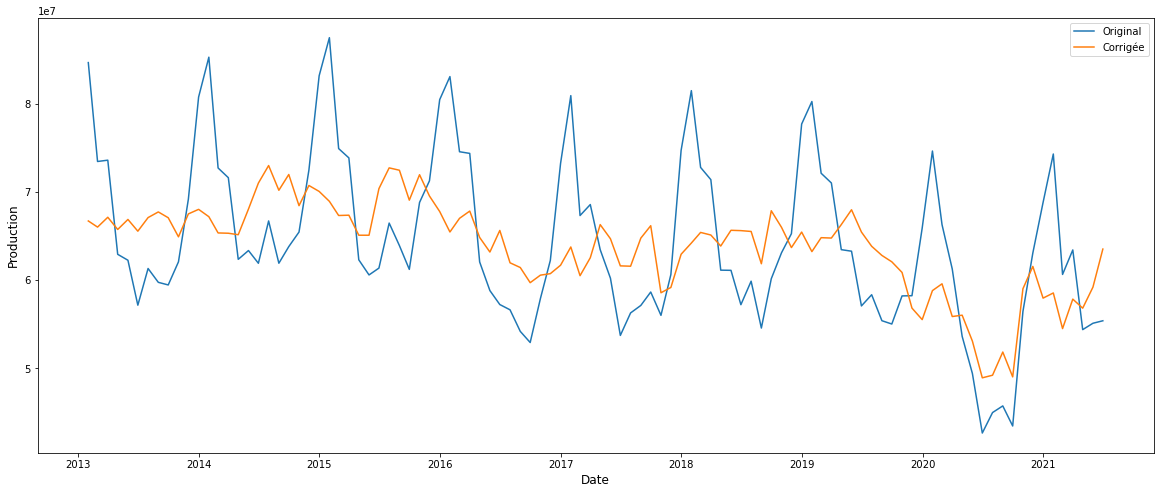

In [50]:
#Comparaison réel vs corrigé des effets saisonniers
time_serie_log = np.log(time_serie)
season_effect = seasonal_decompose(time_serie_log)
cvs = time_serie_log - season_effect.seasonal
x_cvs = np.exp(cvs)

plt.figure(figsize=(20,8))
plt.plot(time_serie, label='Original')
plt.plot(x_cvs, label='Corrigée')
plt.ylabel('Production', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.show();

## Différenciation et modèle

On commence comme précédemment avec une différenciation avec un pas de 1.

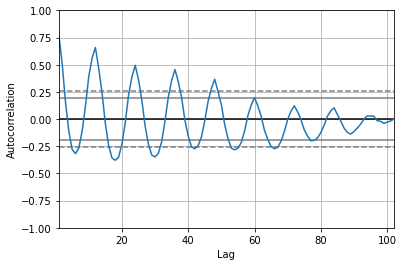

In [51]:
pd.plotting.autocorrelation_plot(time_serie_log);

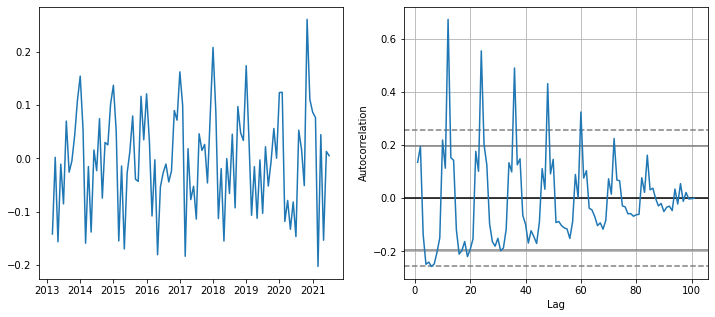

In [52]:
time_serie_log1 = time_serie_log.diff(1).dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(time_serie_log1)
pd.plotting.autocorrelation_plot(time_serie_log1, ax=ax2);

Puis une différenciation sur une saisonnalité de 12.

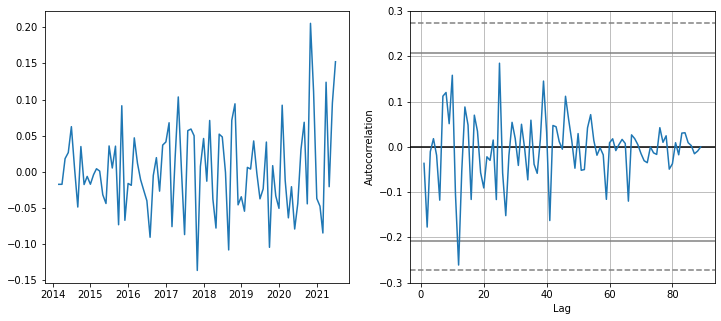

In [53]:
time_serie_log2 = time_serie_log1.diff(12).dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(time_serie_log2)
pd.plotting.autocorrelation_plot(time_serie_log2, ax=ax2);

In [54]:
#P-value de la validité de la stationarité
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(time_serie_log2)
print(f'P-value AdFuller: {p_value}')

P-value AdFuller: 0.0886160224189389


Comme on peut le constater, la p-value du test AdFuller est un petit peu trop élevée. Cependant, il y a une saisonnalité claire de 12 mois dans les données. Nous allons le prendre en compte dans les paramètres du modèle.

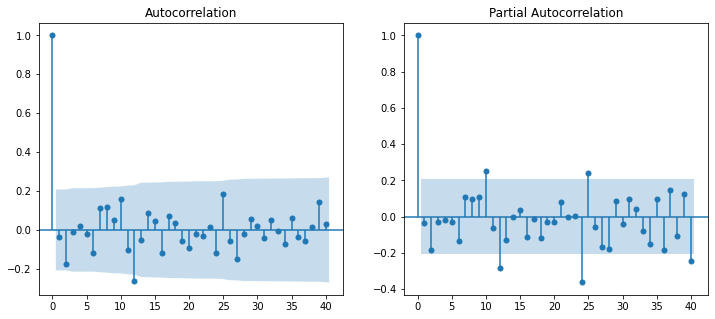

In [55]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
plot_acf(time_serie_log2, ax=ax1, lags = 40)
plot_pacf(time_serie_log2, ax=ax2, lags = 40)
plt.show();

Sur la base des acf et pacf ci-dessus, nous allons prendre P=2 et Q=0 pour les paramètres saisonniers car la pacf s'arrête après l'ordre 2 si on prend les seuils 12/24/36. Pour les paramètres non saisonniers, nous partons sur p=q=1 et nous vérifierons la significativité des paramètres.

In [57]:
model = sm.tsa.SARIMAX(time_serie_log,order=(1,1,1), seasonal_order=(2,1,0,12)) # ou 010
model_fitted = model.fit()
model_fitted.summary()

C:\Users\romat\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      Nucléaire (MW)   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                 135.511
Date:                             Tue, 24 Aug 2021   AIC                           -261.023
Time:                                     11:42:54   BIC                           -248.580
Sample:                                 01-31-2013   HQIC                          -256.007
                                      - 06-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7608      0.121      6.303      0.000       0.524       0.997
ma.L1         -0.9903      0.165     -6.014      0.000      -1.313      -0.668
ar.S.L12      -0.5460      0.159     -3.438      0.001      -0.857      -0.235
ar.S.L24      -0.3929      0.153     -2.574      0.010      -0.692      -0.094
sigma2         0.0025      0.001      4.643      0.000       0.001       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.23
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.85   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Les résidus ne sont clairement pas normalement répartis par le test de Jarque-Bera. Cependant, leur blancheur est assurée par celui de Ljung-Box.

## Prévisions

Les résultats des tests d'erreurs sont plutôt satisfaisants avec une erreur relative moyenne inférieure à 10% et un rmse ne représentant que 7% des observations.

In [58]:
pred_20_21 = np.exp(model_fitted.predict(84,101))
real_20_21 = time_serie.loc['2020-1-31':'2021-06-30']

num = np.sum(np.abs(pred_20_21-real_20_21))/12
denom = np.mean(real_20_21)
error = num/denom
print(f'Erreur moyenne relative: {"{:.1f}".format(error*100)}%')

Erreur moyenne relative: 9.6%


In [59]:
rmse = np.sqrt(mean_squared_error(pred_20_21, real_20_21))
print(f'RMSE Score: {"{:.0f}".format(rmse)}')
print(f'Réel moyen: {"{:.0f}".format(time_serie.mean())}')
print(f'Rapport: {"{:.1f}".format(100*rmse/time_serie.mean())}%')

RMSE Score: 4384876
Réel moyen: 64451454
Rapport: 6.8%


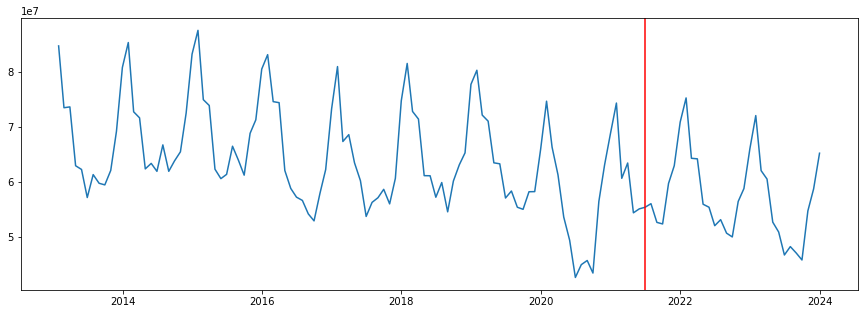

In [60]:
pred = np.exp(model_fitted.predict(102,131))
time_serie_pred = pd.concat([time_serie, pred])
plt.figure(figsize = (15,5))
plt.plot(time_serie_pred)
plt.axvline(x=datetime.date(2021,6,30), color='red')
plt.show();

In [61]:
pred_df['Nucléaire (MW)'] = pred

# Modèle : prévision de production thermique

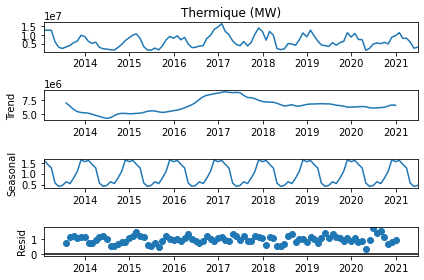

In [62]:
#Analyse du trend selon le pas choisi
time_serie = temp_df['Thermique (MW)']
#BC, lamb = scipy.stats.boxcox(temp_df['Consommation (MW)'])
#time_serie = pd.Series(BC, index=temp_df.index)
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #prob = scipy.stats.boxcox_normplot(time_serie, -2, 2, plot=ax)
season_effect = seasonal_decompose(time_serie, model='multiplicative') #, freq=365
season_effect.plot()
plt.show();

Les résidus sont regroupés ci-dessus autour de 1 mais ne sont pas vraiment stabilisés pour autant. Nous allons tenter un modèle sur cette base et voir ce que cela peut donner.

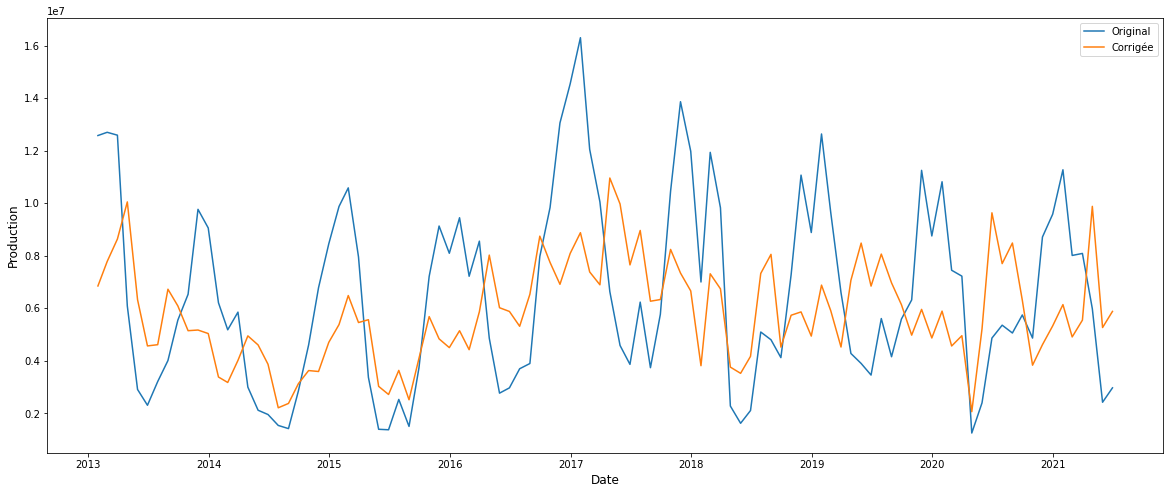

In [63]:
#Comparaison réel vs corrigé des effets saisonniers
time_serie_log = np.log(time_serie)
season_effect = seasonal_decompose(time_serie_log)
cvs = time_serie_log - season_effect.seasonal
x_cvs = np.exp(cvs)

plt.figure(figsize=(20,8))
plt.plot(time_serie, label='Original')
plt.plot(x_cvs, label='Corrigée')
plt.ylabel('Production', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.show();

On remarque que la tendance de production thermique a connu une hausse en 2017 au moment où celle de nucléaire connaissait une baisse. Cela donne l'impression d'une compensation.

## Différenciation et modèle

On commence comme précédemment avec une différenciation avec un pas de 1 puis 12.

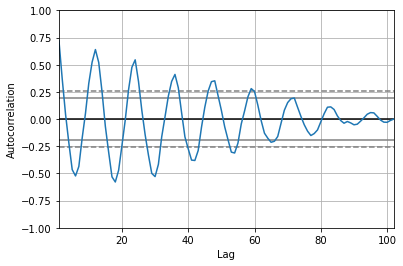

In [64]:
pd.plotting.autocorrelation_plot(time_serie_log);

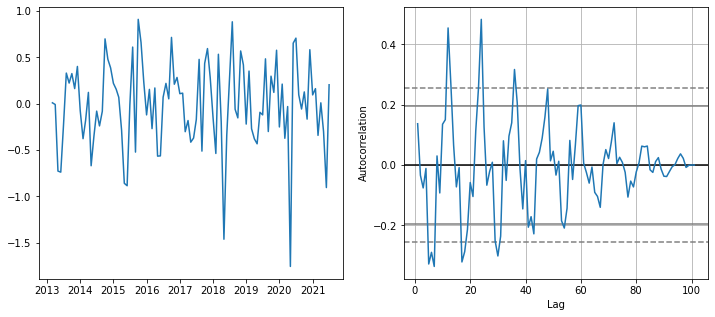

In [65]:
time_serie_log1 = time_serie_log.diff(1).dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(time_serie_log1)
pd.plotting.autocorrelation_plot(time_serie_log1, ax=ax2);

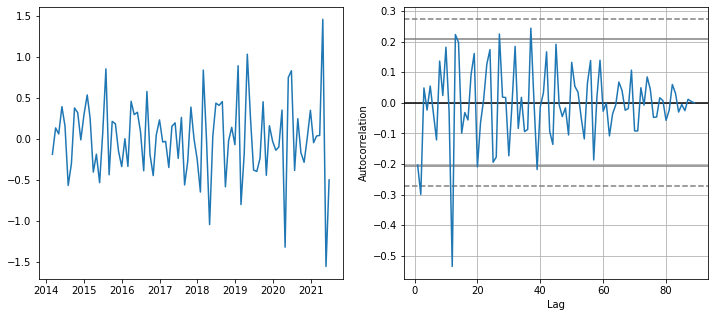

In [66]:
time_serie_log2 = time_serie_log1.diff(12).dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(time_serie_log2)
pd.plotting.autocorrelation_plot(time_serie_log2, ax=ax2);

In [67]:
#P-value de la validité de la stationarité
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(time_serie_log2)
print(f'P-value AdFuller: {p_value}')

P-value AdFuller: 0.011094950357450492


Il s'avère que la série est relativement stationnaire selon le test ci-dessus. Nous pouvons donc continuer le modèle avec une certaine confiance.

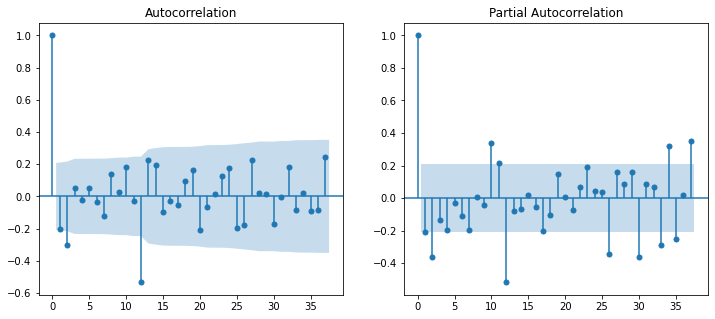

In [68]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
plot_acf(time_serie_log2, ax=ax1, lags = 37)
plot_pacf(time_serie_log2, ax=ax2, lags = 37)
plt.show();

Nous savons que d=1, D=1, m=12. Pour les paramètres non-saisonniers p et q, nous allons commencer avec p et q = 1 car les acf et pacf convergent vite vers 0. En ce qui concerne les paramètres saisonniers, nous allons aussi partir sur P = Q = 1 car on voit que les acf et pacf s'annulent après le rang 12 (quand on considère 12/24/36).

In [69]:
model = sm.tsa.SARIMAX(time_serie_log,order=(1,1,1), seasonal_order=(1,1,1,12))
model_fitted = model.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Thermique (MW)   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -28.579
Date:                            Tue, 24 Aug 2021   AIC                             67.159
Time:                                    11:42:56   BIC                             79.602
Sample:                                01-31-2013   HQIC                            72.174
                                     - 06-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3684      0.164      2.244      0.025       0.047       0.690
ma.L1         -0.7849      0.120     -6.547      0.000      -1.020      -0.550
ar.S.L12      -0.3533      0.145     -2.443      0.015      -0.637      -0.070
ma.S.L12      -0.5036      0.140     -3.596      0.000      -0.778      -0.229
sigma2         0.1000      0.014      7.175      0.000       0.073       0.127
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 6.11
Prob(Q):                              0.82   Prob(JB):                         0.05
Heteroskedasticity (H):               1.77   Skew:                            -0.54
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prévisions

Les résultats des tests d'erreurs sont assez élevés mais la courbe de prévision montre que la saisonnalité globale est respectée. Les erreurs sont dûes à l'aspect beaucoup plus aléatoire de la production thermique (par rapport à la production de renouvelables), avec une saisonnalité moins rigoureuse. Mois à mois, le modèle paraît a minima cohérent.


In [70]:
pred_20_21 = np.exp(model_fitted.predict(84,101))
real_20_21 = time_serie.loc['2020-1-31':'2021-06-30']

num = np.sum(np.abs(pred_20_21-real_20_21))/12
denom = np.mean(real_20_21)
error = num/denom
print(f'Erreur moyenne relative: {"{:.1f}".format(error*100)}%')

Erreur moyenne relative: 36.6%


In [71]:
rmse = np.sqrt(mean_squared_error(pred_20_21, real_20_21))
print(f'RMSE Score: {"{:.0f}".format(rmse)}')
print(f'Réel moyen: {"{:.0f}".format(time_serie.mean())}')
print(f'Rapport: {"{:.1f}".format(100*rmse/time_serie.mean())}%')

RMSE Score: 1889780
Réel moyen: 6552536
Rapport: 28.8%


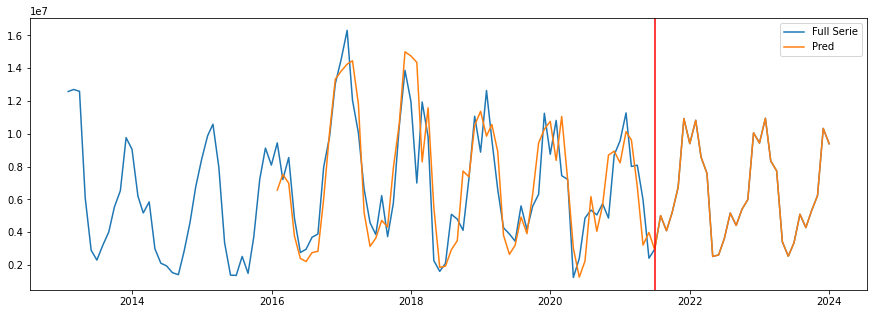

In [72]:
pred = np.exp(model_fitted.predict(102,131))
time_serie_pred = pd.concat([time_serie, pred])
pred_all = np.exp(model_fitted.predict(36,131))

plt.figure(figsize = (15,5))
plt.plot(time_serie_pred, label='Full Serie')
plt.plot(pred_all, label='Pred')
plt.axvline(x=datetime.date(2021,6,30), color='red')
plt.legend()
plt.show();

In [73]:
pred_df['Thermique (MW)'] = pred

# Visualisation des prévisions sur le mix énergétique français

Maintenant que nous disposons de l'ensemble des prévisions sur les productions, nous pouvons donc les visualiser pour anticiper l'évolution du mix énergétique français sur les prochaines années.

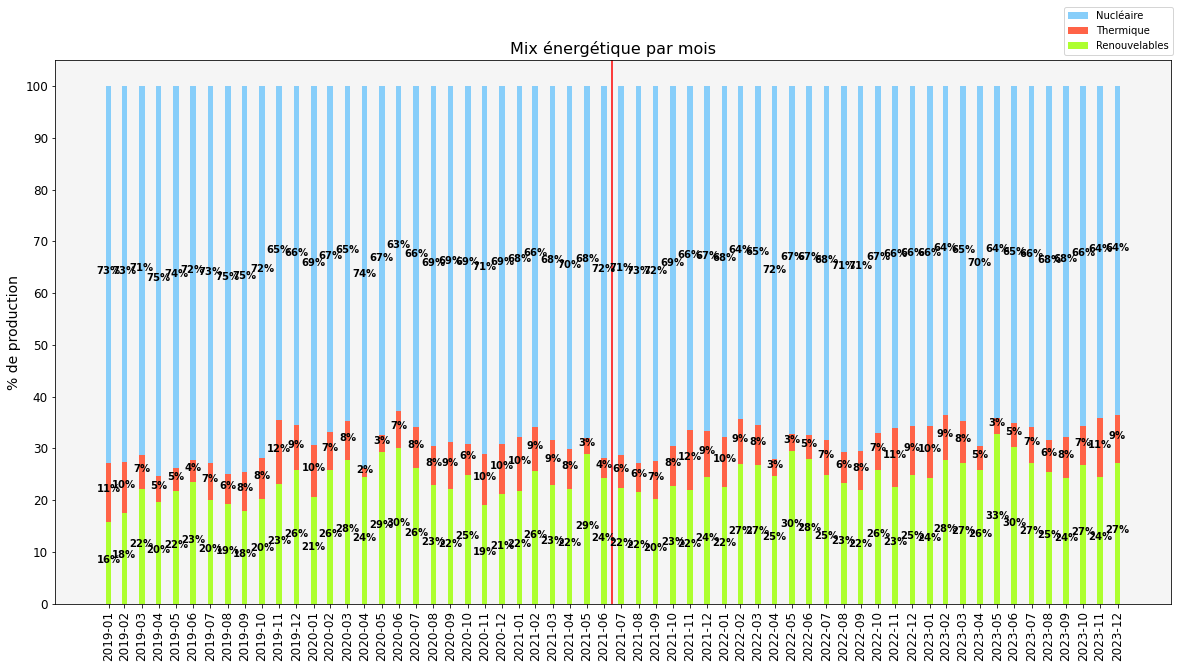

In [133]:
union = temp_df[['Renouvelables (MW)', 'Consommation (MW)', 'Nucléaire (MW)', 'Thermique (MW)']]
mix_df = pd.concat([union, pred_df], axis=0)

mix_df['Production'] = mix_df['Thermique (MW)'] + mix_df['Nucléaire (MW)'] + mix_df['Renouvelables (MW)']
mix_df['Thermique'] = mix_df['Thermique (MW)'] / mix_df['Production']
mix_df['Nucléaire'] = mix_df['Nucléaire (MW)'] / mix_df['Production']
mix_df['Renouvelables'] = mix_df['Renouvelables (MW)'] / mix_df['Production']
mix_df = mix_df.loc['2019-1-31':'2023-12-31']
barwidth=10

fig = plt.figure(figsize=(20,10))
ax4 = fig.add_subplot(111)
graph1 = ax4.bar(x=mix_df.index, height=mix_df['Nucléaire'], bottom = mix_df['Thermique'] + mix_df['Renouvelables'], 
                 label = 'Nucléaire', width = barwidth, color='lightskyblue')
graph2 = ax4.bar(x=mix_df.index, height=mix_df['Thermique'], bottom = mix_df['Renouvelables'], 
                 label = 'Thermique', width = barwidth, color='tomato')
graph3 = ax4.bar(x=mix_df.index, height=mix_df['Renouvelables'], 
                 label = 'Renouvelables', width = barwidth, color='greenyellow')
ax4.axvline(x=datetime.date(2021,7,15), color='red')

ax4.set_facecolor('whitesmoke')
ax4.set_title('Mix énergétique par mois', fontsize=16)
ax4.tick_params(labelsize=12)
ax4.set_xticks(mix_df.index)
ax4.set_xticklabels(mix_df.index.to_period('M'))
ax4.tick_params('x', labelrotation = 90)
ax1.set_ylim([0,1])
ax4.set_yticks(np.arange(0,1.1,0.1))
ax4.set_yticklabels([0,10,20,30,40,50,60,70,80,90,100])
ax4.set_ylabel('% de production', fontsize=14)

#mise en place des pourcentages dans le graphique
graph_list = [graph1, graph2, graph3]
label_list = ['Nucléaire', 'Thermique', 'Renouvelables']
for count, item in enumerate(graph_list):
    i = 0
    for p in item:
        idx = mix_df.index[i]
        label = label_list[count]
        percentage = "{:.0f}".format(round(mix_df.loc[idx,label]*100, 0))
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()/2
        ax4.text(x=x, y=y, s = f'{percentage}%', ha='center', color='black', weight='bold', size=10)
        i += 1
        

ax4.legend(bbox_to_anchor=(0.9, 1))
plt.show();

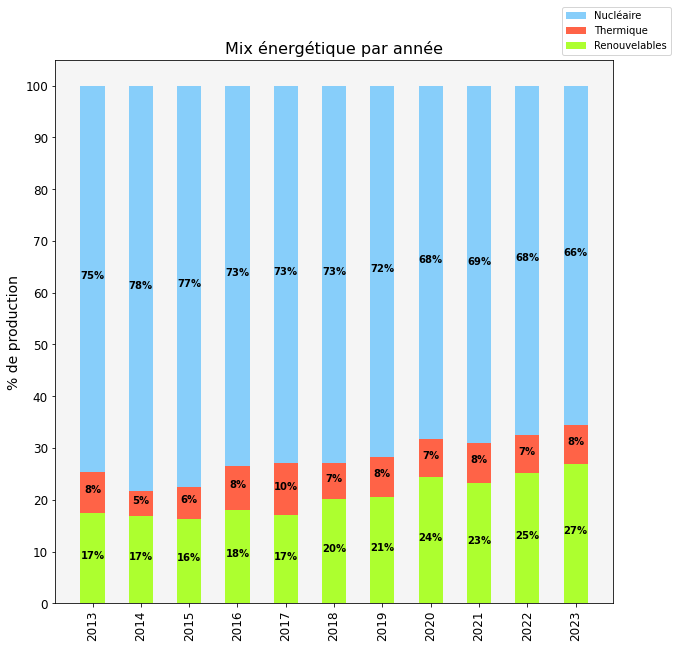

In [134]:
union = temp_df[['Renouvelables (MW)', 'Consommation (MW)', 'Nucléaire (MW)', 'Thermique (MW)']]
mix_df = pd.concat([union, pred_df], axis=0)
mix_df = mix_df.reset_index()

mix_df['year'] = mix_df['index'].dt.year
mix_df = mix_df.groupby(['year']).sum().reset_index()
mix_df['Production'] = mix_df['Thermique (MW)'] + mix_df['Nucléaire (MW)'] + mix_df['Renouvelables (MW)']
mix_df['Thermique'] = mix_df['Thermique (MW)'] / mix_df['Production']
mix_df['Nucléaire'] = mix_df['Nucléaire (MW)'] / mix_df['Production']
mix_df['Renouvelables'] = mix_df['Renouvelables (MW)'] / mix_df['Production']
barwidth=0.5

fig = plt.figure(figsize=(10,10))
ax4 = fig.add_subplot(111)
graph1 = ax4.bar(x=mix_df['year'], height=mix_df['Nucléaire'], bottom = mix_df['Thermique'] + mix_df['Renouvelables'], 
                 label = 'Nucléaire', width = barwidth, color='lightskyblue')
graph2 = ax4.bar(x=mix_df['year'], height=mix_df['Thermique'], bottom = mix_df['Renouvelables'], 
                 label = 'Thermique', width = barwidth, color='tomato')
graph3 = ax4.bar(x=mix_df['year'], height=mix_df['Renouvelables'], 
                 label = 'Renouvelables', width = barwidth, color='greenyellow')

ax4.set_facecolor('whitesmoke')
ax4.set_title('Mix énergétique par année', fontsize=16)
ax4.tick_params(labelsize=12)
ax4.set_xticks(mix_df['year'])
ax4.set_xticklabels(mix_df['year'])
ax4.tick_params('x', labelrotation = 90)
ax1.set_ylim([0,1])
ax4.set_yticks(np.arange(0,1.1,0.1))
ax4.set_yticklabels([0,10,20,30,40,50,60,70,80,90,100])
ax4.set_ylabel('% de production', fontsize=14)

#mise en place des pourcentages dans le graphique
graph_list = [graph1, graph2, graph3]
label_list = ['Nucléaire', 'Thermique', 'Renouvelables']
for count, item in enumerate(graph_list):
    i = 0
    for p in item:
        idx = mix_df.index[i]
        label = label_list[count]
        percentage = "{:.0f}".format(round(mix_df.loc[idx,label]*100, 0))
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()/2
        ax4.text(x=x, y=y, s = f'{percentage}%', ha='center', color='black', weight='bold', size=10)
        i += 1
        

ax4.legend(bbox_to_anchor=(0.9, 1))
plt.show();

**Nos modèles Sarimax prévoient une augmentation régulière de la part des renouvelables dans le mix énergétique français sur la base de la tendance des dernières années.
Nous pouvons également remarquer que cela prend en compte le choc de la pandémie de 2020: le nucléaire étant la variable d'ajustement à la consommation, il a baissé plus fortement en proportion.**